In [50]:
import numpy as np
from scipy.special import comb
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [10]:
observations = np.array(list(map(lambda string: np.array(list(map(lambda x: 1 if x == 'H' else 0, string))),
               ['TTTTHHHTTTHTTTHHTTTT', 'HHHHHHHHHHHHHTTTHHHH','HHHTHHHHHHTHTTHTHHHH'])))

Let $X$ be the observations, $Z$ - hidden parameters (indices of the coins used in each run of the experiment) and 
$\Theta$ - the objective, namely $p_1$ and $p_1$. Since each run is independet of any other,
probabilistic model of our experiment can be expressed as a simple product:

$$ \mathbb{P}\left( X, Z, \Theta \right) = \prod_{i=1}^3 P_i\left(x_i, z_i, \theta_i \right), $$

where
$$ P_i\left(x_i, z_i, \theta_i \right) = \frac{C_{N_{tot}}^{N_H}}{2^{N_{tot}}} \cdot p_{z_i}^{N_H} \cdot \left( 1 - p_{z_i} \right)^{1 - N_H} $$

### Estimate the biases
We can estimate the biases by computing the Maximal Likelihood Estimation. Likelihood function to maximize:
$$ L(p_1, p_2) = \mathbb{P}\left( p_1, p_2\ |\ X \right) = \alpha \sum_Z \mathbb{P}(X, Z, \Theta). $$

In [42]:
hidden_parameters = np.array([np.array([0, 0, 0]),
                              np.array([0, 0, 1]),
                              np.array([0, 1, 0]),
                              np.array([0, 1, 1]),
                              np.array([1, 0, 0]),
                              np.array([1, 0, 1]),
                              np.array([1, 1, 0]),
                              np.array([1, 1, 1])])

Nhead = observations.sum(axis=1)
Ntot = 20
coefs = comb(Ntot, Nhead) / 2**Ntot

def likelihood(p1: float, p2: float) -> float:
    probas = np.array([p1, p2])
    return sum([(coefs * np.power(probas[hidden], Nhead) * np.power(1.0 - probas[hidden], Ntot - Nhead)).prod()
                for hidden in hidden_parameters])

In [46]:
vlikelihood = np.vectorize(likelihood)

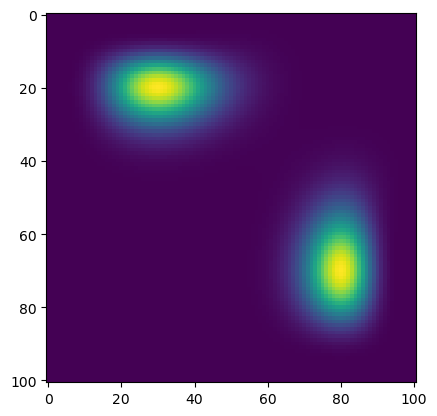

In [74]:
p1_space = np.linspace(0.0, 1.0, 101)
p2_space = np.array([np.linspace(0.0, 1.0, 101)]).transpose()
l = vlikelihood(p1_space, p2_space)
plt.imshow(np.flipud(l))
plt.show()

The function is symmetric. Indeed, we did not specify exactly which coin should be labeled 1 or 2.
Something like $p_1 = 0.8$ and $p_2 = 0.3$ is expected.

In [61]:
initial_simplex = ([[0.2, 0.9], [0.3, 0.6], [0.6, 0.9]])
result = minimize(fun=lambda x: -vlikelihood(x[0], x[1]),
                  method='Nelder-Mead',
                  x0=[0.7, 0.4],
                  options={'initial_simplex' : initial_simplex})
print(result)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -5.9600554474763984e-21
             x: [ 3.001e-01  8.000e-01]
           nit: 30
          nfev: 58
 final_simplex: (array([[ 3.001e-01,  8.000e-01],
                       [ 3.001e-01,  8.000e-01],
                       [ 3.002e-01,  8.000e-01]]), array([-5.960e-21, -5.960e-21, -5.960e-21]))


Eyeballed it!

### A posteriori $ \mathbb{P} \left( \left| p_1 - p_2 \right| < 0.1 \right) $

$$ \mathbb{P} \left( \left| p_1 - p_2 \right| < 0.1 \right) =
    \int_{\left| p_1 - p_2 \right| < 0.1} P(p_1, p_2\ |\ X)dp_1 dp_2, $$
where $P(p_1, p_2\ |\ X)$ is the a posteriori likelihood function.

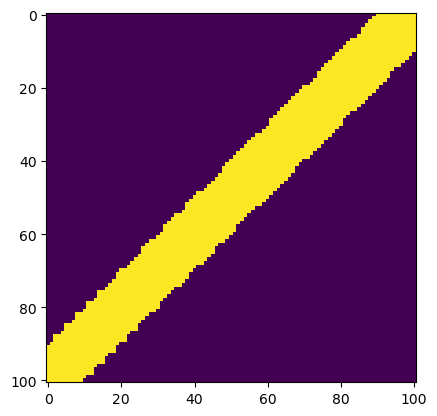

In [70]:
from scipy.integrate import dblquad


area = np.reshape(np.array(list(map(lambda x: 1.0 if x < 0.1 else 0.0,
                                    np.abs(p1_space - p2_space).flatten()))),
                  [len(p1_space), len(p2_space)])
plt.imshow(np.flipud(area))
plt.show()

Comparing the area with the function plot above, we may expect the probability to be very small.

In [84]:
total = dblquad(func=likelihood,
                a=0.0, b=1.0,
                gfun=lambda x: 0.0,
                hfun=lambda x: 1.0)[0]
area = dblquad(func=likelihood,
               a=0.0, b=1.0,
               gfun=lambda x: max(0.0, x - 0.1),
               hfun=lambda x: min(1.0, x + 0.1))[0]
print(f'P(|p1 - p1| < 0.1) = {area / total}')

P(|p1 - p1| < 0.1) = 0.0036308278774949735


### A posteriori probability $Z = (1, 1, 1)$ or $Z = (2, 2, 2)$

Instead of computing the sum ($\approx$ integral) of $\mathbb{P}\left( X, Z, \Theta \right) $ over Z, we may integrate the $\mathbb{P}$
over $d\Theta = dp_1 dp_2$. Knowing the resulting function $\mathbb{P}\left(Z\ |\ X\right) $, it is easy to find the probability in
question, which would be $\mathbb{P}\left(Z = [1,1,1]\ |\ X\right) + \mathbb{P}\left(Z = [2,2,2]\ |\ X\right) $

In [85]:
from functools import reduce
# This function needs to be normalised to be considered likelihood.
def hidden_likelihood(z: list[int]) -> float:
    def integrand(p1: float, p2: float) -> float:
        probas = np.array([p1, p2])
        return (coefs * np.power(probas[z], Nhead) * np.power(1.0 - probas[z], Ntot - Nhead)).prod()
    return dblquad(func=integrand,
                   a=0.0, b=1.0,
                   gfun=lambda x: 0.0,
                   hfun=lambda x: 1.0)[0]

norm = reduce(lambda acc, it: acc + it, (map(hidden_likelihood, hidden_parameters)))
print(f'P(Z=(1,1,1) or Z=(2,2,2) | X) = {(hidden_likelihood([0, 0, 0]) + hidden_likelihood([1, 1, 1])) / norm}')

P(Z=(1,1,1) or Z=(2,2,2) | X) = 0.0028998422016043193
